**Description**:

Compute the Table 4 and 5 of the article.

Compute the figure 7 of the article: Audio quality distribution measure for all recordings in terms of the modulation index and SNR.

Instalation instructions for matlab.engine package can be founded in:
https://www.mathworks.com/help/matlab/matlab_external/python-setup-script-to-install-matlab-engine-api.html

-------------------------------------------------------------------------
Author: Luciano Martinez Rau (Mid Sweden University - sinc(<i>i</i>)-CONICET)
------------------------------------------------------------------------

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import getpass
import os
import matlab.engine
from pydub import AudioSegment

password = getpass.getpass()
command = "sudo -S apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended"
os.system('echo %s | %s' % (password, command))
eng = matlab.engine.start_matlab()

[sudo] password for luciano: 



Reading package lists...
Building dependency tree...
Reading state information...
cm-super is already the newest version (0.3.4-15).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2019.202000218-1).
texlive-latex-recommended is already the newest version (2019.20200218-1).
0 to upgrade, 0 to newly install, 0 to remove and 147 not to upgrade.
1 not fully installed or removed.
After this operation, 0 B of additional disk space will be used.
Do you want to continue? [Y/n] Abort.


**Specify the path of:**

 -MP3AudioInformation.xlsx

 -Folder with the MP3 audio recordings.
 
 -Folder with the JM labels generated automatically (no revised)

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/drive',force_remount=True)
    # path to read the MP3 audio recordings
    folderMP3 = "/drive/My Drive/Colab Notebooks/DatabaseMichigan/data/audio/"
    # path to the MP3AudioInformation.xlsx file
    tableMP3file = '/drive/My Drive/Colab Notebooks/DatabaseMichigan/data/MP3AudioInformation.xlsx'
    # path to save the JM labels
    folderJMlabel = "/drive/My Drive/Colab Notebooks/DatabaseMichigan/data/labels_JMs/"
    fig_directory = '/drive/MyDrive/Colab Notebooks/DatabaseMichigan/fig/'
else:
        # path to read the MP3 audio recordings
    folderMP3 = "/home/luciano/Music/"
    # path to the MP3AudioInformation.xlsx file
    tableMP3file = 'data/MP3AudioInformation.xlsx'
    # path to read the JM labels
    folderJMlabel = "data/labels_JMs/"
    fig_directory = 'fig/'

Computation of the modulation index (MI) and signal-to-noise ratio (SNR) for both channels of the MP3 files

In [4]:
df = pd.read_excel(tableMP3file)
df_latinsquare=pd.DataFrame([],columns=["Day","RS","Ch","mi_grazing","mi_rumination","snr_grazing","snr_rumination"])
df_audiorecordings=pd.DataFrame([],columns=["Day","RS","recoding","mi_grazing","mi_rumination","snr_grazing","snr_rumination"])

# in case that the call to matlab crash, this file serve to load the partial results to continue
temporal_file = "temp.txt"

if os.path.exists(temporal_file):
    with open(temporal_file, 'r') as file:
        last_index=float(file.read())
    df_latinsquare = pd.read_csv("df_latinsquare.csv")
    df_audiorecordings = pd.read_csv("df_audiorecordings.csv")
else:
    last_index=-1

# read channel
for index, row in df.iterrows():
    if (index>last_index):
        mp3file = df["Name file"][index]
        JMlabelfile = folderJMlabel + os.path.splitext(mp3file)[0] + "_JM.txt"
        activityfilename = os.path.splitext(mp3file)[0] + ".txt"
        
        ch_inward = df["Channel 1 is the microphone facing…"][index]
        if (ch_inward=="inwards") or (ch_inward=="-") :
            ch_inward = 0
        else:
            ch_inward = 1
        
        # Load an MP3 file
        audio = AudioSegment.from_mp3(folderMP3+mp3file)

        #convert MP3 to mono WAV
        temp_wav = "temporal.wav"
        audio_monos = audio.split_to_mono()
        for channel in range (0,2):
            desired_channel = audio_monos[channel]
            desired_channel.export(temp_wav,format="wav")

            #call MATLAB to compute the MI and SNR values
            re = eng.estimate_snr_mi_inward(folderMP3+activityfilename,JMlabelfile,temp_wav,nargout=4)
            
            #save results to analise the latin-square design
            latinsquare_results = {"Day":mp3file[1],"RS":mp3file[4],"Ch":channel,"mi_grazing":re[0],"mi_rumination":re[1],"snr_grazing":re[2],"snr_rumination":re[3]}
            df_latinsquare.loc[len(df_latinsquare)] = latinsquare_results

            if (ch_inward==channel):
                #save results to analise the inward channel of each audio recording
                recording_results = {"Day":mp3file[1],"RS":mp3file[4],"recoding":mp3file[mp3file.index("P")+1],"mi_grazing":re[0],"mi_rumination":re[1],"snr_grazing":re[2],"snr_rumination":re[3]}
                df_audiorecordings.loc[len(df_audiorecordings)] = recording_results

        #write temporary results in case of crash
        with open(temporal_file, 'w') as file:
            file.write(str(index))
        df_latinsquare.to_csv("df_latinsquare.csv",index=False)
        df_audiorecordings.to_csv("df_audiorecordings.csv",index=False)

Compute table 4 and 5

In [5]:
df_LS_mean=pd.DataFrame([],columns=["Day","RS","Ch","mean_mi_grazing","mean_mi_rumination","mean_snr_grazing","mean_snr_rumination"])

for i in range(1,int(max(df_latinsquare["Day"]))+1):
    for j in range(1,int(max(df_latinsquare["RS"]))+1):
        for k in range(0,int(max(df_latinsquare["Ch"]))+1):
            dfaux = df_latinsquare[(df_latinsquare['Day'] == str(i)) & (df_latinsquare['RS'] == str(j)) & (df_latinsquare['Ch'] == k)].copy()
            mi_grazing_mean = round(dfaux["mi_grazing"].mean(),2)
            mi_rumination_mean = round(dfaux["mi_rumination"].mean(),2)
            snr_grazing_mean = round(dfaux["snr_grazing"].mean(),2)
            snr_rumination_mean = round(dfaux["snr_rumination"].mean(),2)
            df_LS_mean.loc[len(df_LS_mean)] = {"Day":i,"RS":j,"Ch":k+1,"mean_mi_grazing":mi_grazing_mean,
                                               "mean_mi_rumination":mi_rumination_mean,"mean_snr_grazing":snr_grazing_mean,
                                               "mean_snr_rumination":snr_rumination_mean}

print(df_LS_mean)

    Day  RS  Ch  mean_mi_grazing  mean_mi_rumination  mean_snr_grazing   
0     1   1   1              NaN                 NaN               NaN  \
1     1   1   2              NaN                 NaN               NaN   
2     1   2   1              NaN                 NaN               NaN   
3     1   2   2              NaN                 NaN               NaN   
4     1   3   1              NaN                 NaN               NaN   
5     1   3   2              NaN                 NaN               NaN   
6     1   4   1              NaN                 NaN               NaN   
7     1   4   2              NaN                 NaN               NaN   
8     1   5   1              NaN                 NaN               NaN   
9     1   5   2              NaN                 NaN               NaN   
10    2   1   1              NaN                 NaN               NaN   
11    2   1   2              NaN                 NaN               NaN   
12    2   2   1              NaN      

Save results

In [6]:
df_LS_mean.to_csv("results_LS.txt",sep="\t",index=False)
df_audiorecordings.to_csv("results_fig7.txt",sep="\t",index=False)

Generate figure 7

/tmp/ipykernel_422605/431979036.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_audiorecordings["mi_grazing"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
/home/luciano/virtualenv/python3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_422605/431979036.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please ada

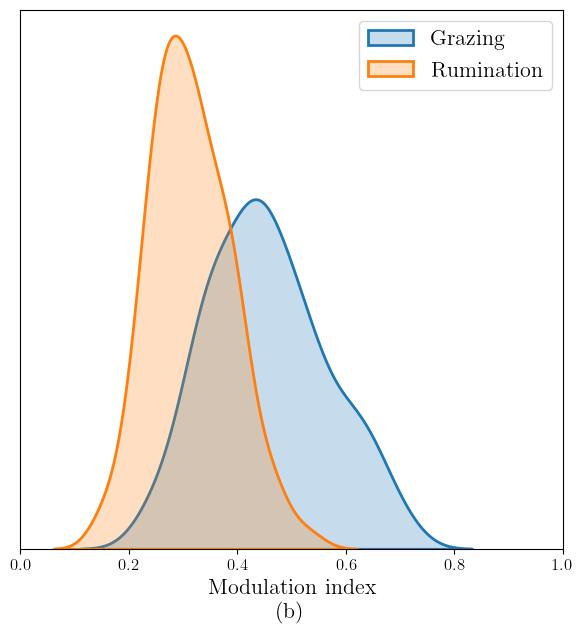

In [14]:
fig,ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
plt.rcParams['text.usetex'] = True
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
 
labels = ["Grazing" , "Rumination"]

sns.distplot(df_audiorecordings["mi_grazing"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
             label = labels[0])
sns.distplot(df_audiorecordings["mi_rumination"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
             label = labels[1])

ax.legend(fontsize=16)
ax.set_xlabel('Modulation index\n\n(a)',fontsize=16)
ax.set_xlim((0,1))

ax.axes.set_yticklabels(labels=[])
ax.set_ylabel('')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', length =0)

plt.savefig(fig_directory + 'audio_quality_a.jpg', dpi = 900,transparent=True,bbox_inches='tight')
plt.savefig(fig_directory + 'audio_quality_a.pdf', dpi = 900,transparent=True,bbox_inches='tight')

/tmp/ipykernel_422605/1154668214.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_audiorecordings["snr_grazing"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
/home/luciano/virtualenv/python3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_422605/1154668214.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please 

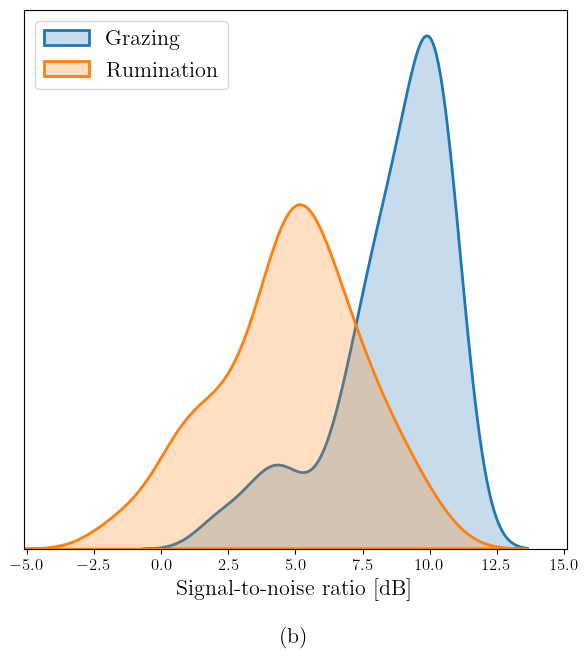

In [25]:
fig,ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
plt.rcParams['text.usetex'] = True
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
 
labels = ["Grazing" , "Rumination"]

sns.distplot(df_audiorecordings["snr_grazing"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
             label = labels[0])
sns.distplot(df_audiorecordings["snr_rumination"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
             label = labels[1])

ax.legend(fontsize=16,loc="upper left")
ax.set_xlabel('Signal-to-noise ratio [dB]\n\n(b)',fontsize=16)
ax.set_xlim((-5.1,15.1))

ax.axes.set_yticklabels(labels=[])
ax.set_ylabel('')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', length =0)

plt.savefig(fig_directory + 'audio_quality_b.jpg', dpi = 900,transparent=True,bbox_inches='tight')
plt.savefig(fig_directory + 'audio_quality_b.pdf', dpi = 900,transparent=True,bbox_inches='tight')

/tmp/ipykernel_422605/3067565296.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_audiorecordings["mi_grazing"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
/home/luciano/virtualenv/python3.8.10/lib/python3.8/site-packages/seaborn/distributions.py:2511: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/tmp/ipykernel_422605/3067565296.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please a

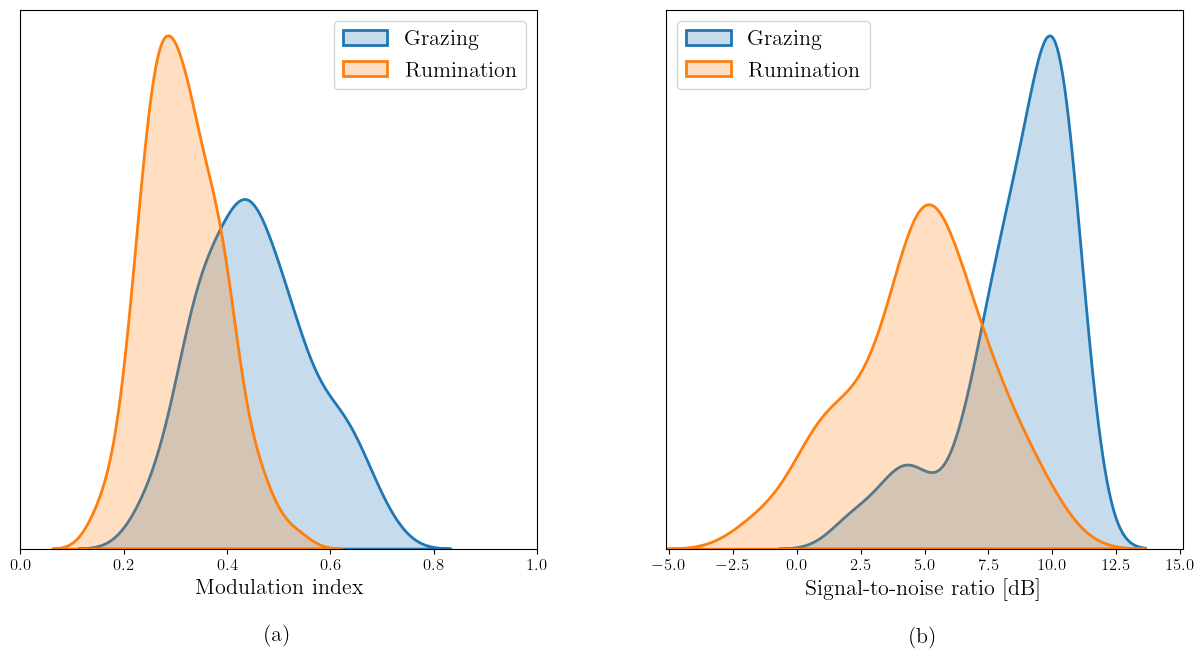

In [24]:
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.rcParams['text.usetex'] = True
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
 
labels = ["Grazing" , "Rumination"]

plt.subplots_adjust(hspace=0.3 , wspace=0.25)
ax1 = plt.subplot2grid(shape=(1,2), loc=(0,0))
ax2 = plt.subplot2grid(shape=(1,2), loc=(0, 1))

sns.distplot(df_audiorecordings["mi_grazing"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
             label = labels[0],ax = ax1)
sns.distplot(df_audiorecordings["mi_rumination"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
             label = labels[1],ax = ax1)

ax1.legend(fontsize=16)
ax1.set_xlabel('Modulation index\n\n(a)',fontsize=16)
ax1.set_xlim((0,1))

ax1.axes.set_yticklabels(labels=[])
ax1.set_ylabel('')

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', length =0)


sns.distplot(df_audiorecordings["snr_grazing"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
             label = labels[0],ax=ax2)
sns.distplot(df_audiorecordings["snr_rumination"], hist = False, kde = True,kde_kws = {'shade': True, 'linewidth': 2},
             label = labels[1],ax=ax2)

ax2.legend(fontsize=16,loc="upper left")
ax2.set_xlabel('Signal-to-noise ratio [dB]\n\n(b)',fontsize=16)
ax2.set_xlim((-5.1,15.1))

ax2.axes.set_yticklabels(labels=[])
ax2.set_ylabel('')

ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', length =0)

plt.savefig(fig_directory + 'fig7.jpg', dpi = 900,transparent=True,bbox_inches='tight')
plt.savefig(fig_directory + 'fig7.pdf', dpi = 900,transparent=True,bbox_inches='tight')